# Waveform
> @author: Jiheng Duan

## About

This document will demonstrate how to plot waveform directly from `qusim.PulseGen.edges`

### Required Import

**The following thing must be import.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# This on is a path correcting code, which is used to find the path of qusim.
sys.path.append('../..')

# auto reload
%load_ext autoreload
%autoreload 2 

import qusim.PulseGen.edges as edges
import qusim.PulseGen.pulse_waveform as pw
import qusim.DataPlot.plot_lib as pl

def carrier(tlist , freq , ph=0 , imb=0 ):
    A = np.cos( np.pi/4 + imb) * np.sqrt(2)  ; 
    B = np.sin( np.pi/4 + imb) * np.sqrt(2)  ; 
    return A * np.cos( 2*np.pi*freq*tlist + ph) + 1j*B*np.sin( 2*np.pi*freq* tlist + ph) ; 


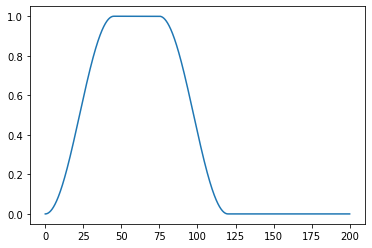

In [4]:
tlist = np.linspace(0,40,50000)
t_delay = 0
t_width = 20
t_plateau = 0
simulation_option = {
    "simulation_time": 40, # ns
    "simulation_step": 10000
}
pw

# c = carrier(tlist, 3, 0)
# YY = edges.cosine_edge(tlist, t_delay, t_width, t_plateau)
# YY *= c
# YY *= 0.05
plt.plot(tlist, np.real(YY))

In [40]:
aa = np.array([1,1,1,1,1], dtype= complex)
bb = np.array([2 + 1j,3,4,5,6], dtype= complex)
aa *= bb
aa

array([2.+1.j, 3.+0.j, 4.+0.j, 5.+0.j, 6.+0.j])

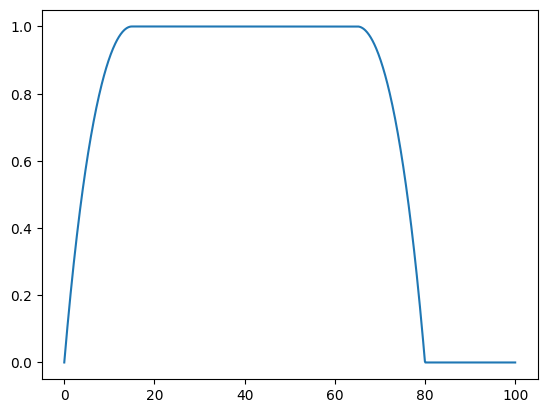

In [59]:
tlist = np.linspace(0,100,1000)
t_delay = 0
t_width = 30
t_plateau = 50
YY = edges.hyper_edge(tlist, t_delay, t_width, t_plateau, 3)
plt.plot(tlist, YY)

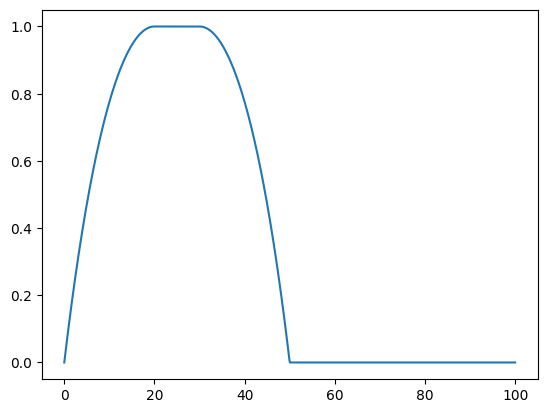

In [17]:
tlist = np.linspace(0,100,1000)
t_delay = 0
t_width = 40
t_plateau = 10
YY = edges.hcosh_edge(tlist, t_delay, t_width, t_plateau)
plt.plot(tlist, YY)

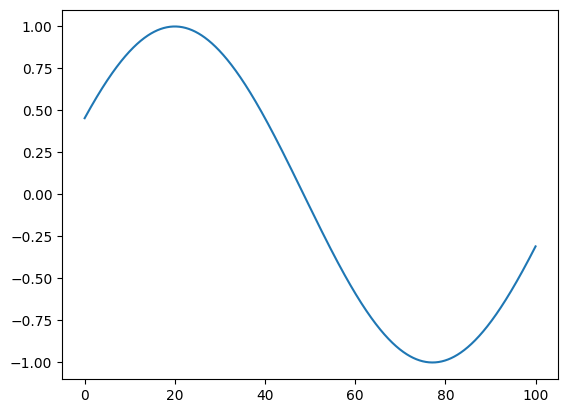

In [18]:
Y = np.cos(edges.rasing_t(tlist, t_delay, t_width, 0.3, 1))
plt.plot(tlist, Y)

## Noise channel test

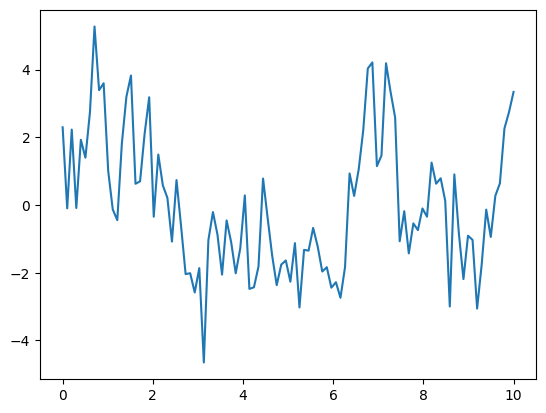

In [7]:
import numpy as np
import numpy.fft as fft

def noise_gen(tstart, tstop, tstep, config):
    """
    Generate noise to be added to a qubit control pulse.

    Parameters:
    - tstart: Start time of the simulation.
    - tstop: Stop time of the simulation.
    - tstep: Time step of the simulation.
    - config: Dictionary containing noise configuration. 
              It includes noise type, parameters, noise starting and stopping time.

    Returns:
    - noise: A numpy array containing the generated noise over time.
    """
    
    # Time array
    t = np.linspace(tstart, tstop, tstep)
    dt = t[1] - t[0]
    noise = np.zeros_like(t)

    switch = config.get('switch', 'off')
    if isinstance(switch, str):
        if switch in ['on', 'off']:
            if switch == 'off': return noise
        else: raise(ValueError('Invalid switch: {switch}, str(on) and str(off) only.'))
    else: raise(ValueError('Invalid switch type: {switch}, str(on) and str(off) only.'))

    # Check for the type of noise and generate accordingly
    noise_type = config.get('type', '').lower()
    
    if noise_type == 'gaussian':
        mean = config.get('mean', 0)
        std = config.get('std', 1)
        noise = np.random.normal(mean, std, t.shape)
        
    elif noise_type == 'white':
        # White noise is Gaussian noise with a flat spectral density
        std = config.get('std', 1)
        noise = np.random.normal(0, std, t.shape)
        
    elif noise_type == 'rt':
        # Random telegraphic noise alternates between two values at random intervals
        high = config.get('high', 1)
        low = config.get('low', -1)
        p_switch = config.get('p_switch', 0.01)  # Probability to switch value
        value = low
        for i in range(len(noise)):
            noise[i] = value
            if np.random.rand() < p_switch:
                value = high if value == low else low

    elif noise_type == 'jn':
        kB = 1.38e-23  # Boltzmann constant in J/K
        temperature = config.get('temperature', 300)  # Room temperature default
        resistance = config.get('resistance', 1)  # Resistance in Ohms
        
        # Johnson-Nyquist noise voltage (RMS)
        V_noise_rms = np.sqrt(4 * kB * temperature * resistance)
        
        # Since Johnson noise is white, we model it as Gaussian noise with a standard deviation of V_noise_rms
        noise = np.random.normal(0, V_noise_rms, t.shape)

    elif noise_type == '1/f':
        alpha = config.get('alpha', 1.0)  # Exponent in the 1/f^alpha relationship
        scale = config.get('scale', 1.0)  # Scale to control the noise amplitude

        # Create white noise as a base
        white_noise = np.random.normal(0, 1, t.shape)

        # Perform FFT
        f_transform = fft.fft(white_noise)

        # Generate frequency axis and avoid division by zero
        freq = fft.fftfreq(t.size, d=tstep)
        freq[0] = 1  # To avoid division by zero at the zero frequency

        # Adjust amplitude by 1/f^alpha
        f_adjusted = f_transform / np.abs(freq) ** (alpha / 2.0)

        # Inverse FFT to get back to time domain
        pink_noise = np.real(fft.ifft(f_adjusted))

        # Normalize to standard normal distribution
        pink_noise = (pink_noise - np.mean(pink_noise)) / np.std(pink_noise)

        # Apply the scale parameter to control the noise amplitude
        noise = pink_noise * scale

    elif noise_type == 'bistable':
        # Bistable noise alternates between two values with non-Markovian switching characteristics
        high = config.get('high', 1)
        low = config.get('low', -1)
        rate = config.get('rate', 0.1)  # Average rate of switching
        state_duration = 0  # Track duration in the current state
        
        # Initial state
        value = low if np.random.rand() < 0.5 else high
        noise[0] = value
        
        for i in range(1, len(noise)):
            noise[i] = value
            # Increase state duration
            state_duration += dt
            
            # Switching probability can depend on the state duration to introduce memory effect
            # For simplicity, we use a fixed rate here
            if np.random.rand() < rate * dt:
                value = high if value == low else low
                state_duration = 0  # Reset state duration after switching
    # Other noise types can be added here following a similar pattern
    # Apply noise only within the specified start and stop times, if given
    noise_start = config.get('noise_start', tstart)
    noise_stop = config.get('noise_stop', tstop)
    noise[(t < noise_start) | (t > noise_stop)] = 0
    
    return noise

# Example usage
config = {
    'type': '1/f',
    'switch': 'on',
    'mean': 0,
    'std': 0.1,
    'noise_start': 0,
    'noise_stop': 10,
    'p_switch': 0.3,
    'alpha': 1,
    'rate': 1,
    'scale':2
}
noise = noise_gen(0, 10, 100, config)
t_list= np.linspace(0,10,100)
# Now, add this noise to your original control pulse as needed
plt.plot(t_list, noise)

### Add to pulse lib, 

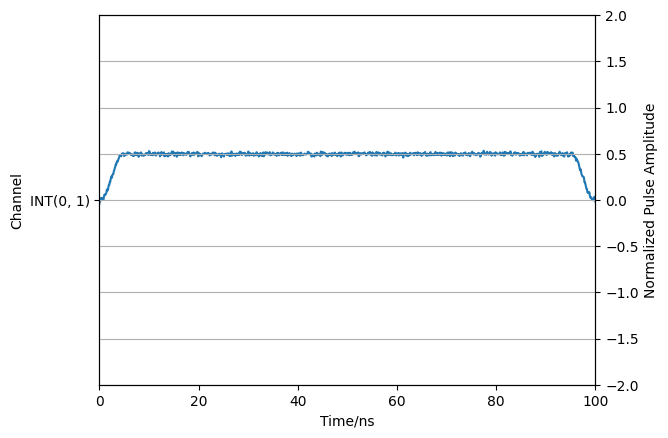

0

In [50]:
t_width =10
simulation_option = {
    "simulation_time" : 100,
    "simulation_step" : 1000
}

noise_chan = [
    {
    'type': 'rt',
    'switch': 'on',
    'std': 0.1,
    'p_switch': 0.3,
    'low': -0.01,
    'high': 0.003
    },
    {
    'type': 'white',
    'switch': 'on',
    'std': 0.01,
    }
]
pulse_sq = [
{
    'pulse_index': 0, # starts form 0
    'type': "INT", # XY, Z, INT
    'pulse_shape': "cosine",
    't_delay': 0, # unit in ns
    't_width': t_width, # unit in ns
    't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
    'freq': 0, # unit in GHz; Z pulse does not use it
    'phase': 0, # unit in rad; Z pulse does not use it
    'amplitude': 0.5, # XY: Rabi freq; Z: biased frequency
    'q_index': (0,1),
    'noise': noise_chan
}
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sq, simulation_option)

In [ ]:
# Example usage
config = {
    'type': 'bistable',
    'switch': 'on',
    'mean': 0,
    'std': 0.1,
    'noise_start': 0,
    'noise_stop': 10,
    'p_switch': 0.3,
    'alpha': 1,
    'rate': 1
}
noise = noise_gen(0, 10, 100, config)
t_list= np.linspace(0,10,100)
# Now, add this noise to your original control pulse as needed
plt.plot(t_list, noise)